# Imports and General Settings

In [1]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

ModuleNotFoundError: No module named 'tfplot'

# Data Augmentation

In [ ]:
# data augmentation methods in data_augmentation_utility.py

def augment_image(image):
                       
    image = da_util.rotate(image)
    image = da_util.flip(image)
    
    image = da_util.translate(image)
    image = da_util.crop(image)

    return image

# ConvNet

## ConvNet Architecture

In [ ]:
num_classes = 3

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [41]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

num_steps = 10000

convnet_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.00]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/"

sets = ["original_inital_labels", "original_new_labels", "balanced_train_set", "whole_set_balanced" ]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:


                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                eval_paths = load_data_util.load_image_paths(eval_root)

                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


                model_path = convnet_checkpoint_path_base + "dt_set/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

/data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff2d34c9588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
I

INFO:tensorflow:loss = 2.112173e-06, step = 620 (6.450 sec)
INFO:tensorflow:global_step/sec: 6.43172
INFO:tensorflow:loss = 2.9804867e-05, step = 640 (3.110 sec)
INFO:tensorflow:global_step/sec: 5.30489
INFO:tensorflow:loss = 1.8253871e-07, step = 660 (3.770 sec)
INFO:tensorflow:global_step/sec: 5.453
INFO:tensorflow:loss = 7.1029346e-05, step = 680 (3.667 sec)
INFO:tensorflow:global_step/sec: 5.38202
INFO:tensorflow:loss = 3.1292285e-07, step = 700 (3.718 sec)
INFO:tensorflow:global_step/sec: 5.26339
INFO:tensorflow:loss = 0.0, step = 720 (3.799 sec)
INFO:tensorflow:global_step/sec: 5.43103
INFO:tensorflow:loss = 2.1176293e-05, step = 740 (3.682 sec)
INFO:tensorflow:global_step/sec: 5.43725
INFO:tensorflow:loss = 8.940684e-08, step = 760 (3.678 sec)
INFO:tensorflow:Saving checkpoints for 767 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorfl

INFO:tensorflow:global_step/sec: 2.90608
INFO:tensorflow:loss = 6.4446874e-07, step = 1380 (6.883 sec)
INFO:tensorflow:global_step/sec: 6.58732
INFO:tensorflow:loss = 4.0454765e-06, step = 1400 (3.036 sec)
INFO:tensorflow:global_step/sec: 5.28091
INFO:tensorflow:loss = 1.4901159e-08, step = 1420 (3.789 sec)
INFO:tensorflow:global_step/sec: 5.67235
INFO:tensorflow:loss = 1.5385086e-06, step = 1440 (3.525 sec)
INFO:tensorflow:global_step/sec: 5.95879
INFO:tensorflow:loss = 3.4308803e-06, step = 1460 (3.355 sec)
INFO:tensorflow:global_step/sec: 5.43311
INFO:tensorflow:loss = 2.0004463e-06, step = 1480 (3.681 sec)
INFO:tensorflow:global_step/sec: 5.57274
INFO:tensorflow:loss = 4.7940807e-06, step = 1500 (3.589 sec)
INFO:tensorflow:global_step/sec: 5.53648
INFO:tensorflow:loss = 1.0765968e-06, step = 1520 (3.613 sec)
INFO:tensorflow:Saving checkpoints for 1532 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2145: /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt-2145
INFO:tensorflow:global_step/sec: 3.4891
INFO:tensorflow:loss = 1.3671709e-06, step = 2160 (5.734 sec)
INFO:tensorflow:global_step/sec: 5.28626
INFO:tensorflow:loss = 2.7044448e-06, step = 2180 (3.783 sec)
INFO:tensorflow:global_step/sec: 5.33279
INFO:tensorflow:loss = 1.117587e-08, step = 2200 (3.750 sec)
INFO:tensorflow:global_step/sec: 5.02337
INFO:tensorflow:loss = 1.08033234e-07, step = 2220 (3.982 sec)
INFO:tensorflow:global_step/sec: 5.23272
INFO:tensorflow:loss = 3.0099407e-06, step = 2240 (3.821 sec)
INFO:tensorflow:global_step/sec: 5.19386
INFO:tensorflow:loss = 1.4901126e-07, step = 2260 (3.853 sec)
INFO:tensorflow:global_step/sec: 5.28189
INFO:tensorflow:loss = 4.7533076e-06, step = 2280 (3.785 sec)
INFO:tensorflow:Saving checkpoints for 2292 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2910: /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt-2910
INFO:tensorflow:global_step/sec: 3.49426
INFO:tensorflow:loss = 1.7508827e-07, step = 2920 (5.724 sec)
INFO:tensorflow:global_step/sec: 5.7722
INFO:tensorflow:loss = 2.466045e-06, step = 2940 (3.465 sec)
INFO:tensorflow:global_step/sec: 5.45349
INFO:tensorflow:loss = 1.7722012e-06, step = 2960 (3.667 sec)
INFO:tensorflow:global_step/sec: 5.472
INFO:tensorflow:loss = 9.201332e-07, step = 2980 (3.655 sec)
INFO:tensorflow:global_step/sec: 5.45213
INFO:tensorflow:loss = 6.109417e-07, step = 3000 (3.669 sec)
INFO:tensorflow:global_step/sec: 5.41143
INFO:tensorflow:loss = 8.940569e-07, step = 3020 (3.695 sec)
INFO:tensorflow:global_step/sec: 5.26427
INFO:tensorflow:loss = 3.725288e-08, step = 3040 (3.799 sec)
INFO:tensorflow:global_step/sec: 5.58385
INFO:tensorflow:loss = 1.2665961e-07, step = 3060 (3.582 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 1.199538e-06, step = 3760 (3.767 sec)
INFO:tensorflow:global_step/sec: 5.35593
INFO:tensorflow:loss = 0.0, step = 3780 (3.735 sec)
INFO:tensorflow:global_step/sec: 5.24329
INFO:tensorflow:loss = 1.6763761e-07, step = 3800 (3.814 sec)
INFO:tensorflow:global_step/sec: 5.43041
INFO:tensorflow:loss = 5.66239e-07, step = 3820 (3.683 sec)
INFO:tensorflow:Saving checkpoints for 3837 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-06-20:26:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt-3837
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-06-20:26:47
INFO:tensorflow:Saving dict for global

INFO:tensorflow:global_step/sec: 5.56297
INFO:tensorflow:loss = 6.0349447e-07, step = 4520 (3.594 sec)
INFO:tensorflow:global_step/sec: 5.4606
INFO:tensorflow:loss = 1.1175869e-08, step = 4540 (3.664 sec)
INFO:tensorflow:global_step/sec: 5.53575
INFO:tensorflow:loss = 9.387654e-07, step = 4560 (3.613 sec)
INFO:tensorflow:global_step/sec: 5.72662
INFO:tensorflow:loss = 3.72529e-09, step = 4580 (3.491 sec)
INFO:tensorflow:Saving checkpoints for 4600 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-06-20:29:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt-4600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-

INFO:tensorflow:loss = 9.0523935e-07, step = 5260 (3.625 sec)
INFO:tensorflow:global_step/sec: 5.38932
INFO:tensorflow:loss = 7.2269796e-07, step = 5280 (3.712 sec)
INFO:tensorflow:global_step/sec: 5.49947
INFO:tensorflow:loss = 5.8859274e-07, step = 5300 (3.636 sec)
INFO:tensorflow:global_step/sec: 5.48555
INFO:tensorflow:loss = 1.19209076e-07, step = 5320 (3.646 sec)
INFO:tensorflow:global_step/sec: 5.50817
INFO:tensorflow:loss = 1.6763761e-07, step = 5340 (3.632 sec)
INFO:tensorflow:global_step/sec: 5.46085
INFO:tensorflow:loss = 1.9743979e-07, step = 5360 (3.661 sec)
INFO:tensorflow:Saving checkpoints for 5367 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-06-20:31:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/synthetic_data/convnet/whole_set_balanced

INFO:tensorflow:global_step/sec: 5.47316
INFO:tensorflow:loss = 4.9918737e-07, step = 6020 (3.654 sec)
INFO:tensorflow:global_step/sec: 5.51076
INFO:tensorflow:loss = 1.6763761e-07, step = 6040 (3.628 sec)
INFO:tensorflow:global_step/sec: 5.79292
INFO:tensorflow:loss = 6.1467085e-07, step = 6060 (3.454 sec)
INFO:tensorflow:global_step/sec: 5.69939
INFO:tensorflow:loss = 4.1350563e-07, step = 6080 (3.508 sec)
INFO:tensorflow:global_step/sec: 5.80637
INFO:tensorflow:loss = 7.45058e-09, step = 6100 (3.444 sec)
INFO:tensorflow:global_step/sec: 5.57529
INFO:tensorflow:loss = 4.880108e-07, step = 6120 (3.588 sec)
INFO:tensorflow:Saving checkpoints for 6132 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-06-20:34:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/synt

INFO:tensorflow:loss = 1.4528598e-07, step = 6760 (5.999 sec)
INFO:tensorflow:global_step/sec: 5.6657
INFO:tensorflow:loss = 2.2351666e-07, step = 6780 (3.531 sec)
INFO:tensorflow:global_step/sec: 5.70521
INFO:tensorflow:loss = 1.7881342e-07, step = 6800 (3.504 sec)
INFO:tensorflow:global_step/sec: 5.8733
INFO:tensorflow:loss = 1.4901158e-08, step = 6820 (3.405 sec)
INFO:tensorflow:global_step/sec: 5.70764
INFO:tensorflow:loss = 5.5879305e-08, step = 6840 (3.506 sec)
INFO:tensorflow:global_step/sec: 5.40179
INFO:tensorflow:loss = 3.72529e-09, step = 6860 (3.701 sec)
INFO:tensorflow:global_step/sec: 5.52714
INFO:tensorflow:loss = 5.8486955e-07, step = 6880 (3.619 sec)
INFO:tensorflow:Saving checkpoints for 6899 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-06-20:36:47
INFO:tensorflow:Graph was finalized.
I

INFO:tensorflow:global_step/sec: 3.40082
INFO:tensorflow:loss = 5.215402e-08, step = 7520 (5.880 sec)
INFO:tensorflow:global_step/sec: 5.47385
INFO:tensorflow:loss = 3.2037457e-07, step = 7540 (3.653 sec)
INFO:tensorflow:global_step/sec: 5.46486
INFO:tensorflow:loss = 0.0, step = 7560 (3.661 sec)
INFO:tensorflow:global_step/sec: 5.23029
INFO:tensorflow:loss = 4.470345e-08, step = 7580 (3.823 sec)
INFO:tensorflow:global_step/sec: 5.55138
INFO:tensorflow:loss = 8.940684e-08, step = 7600 (3.603 sec)
INFO:tensorflow:global_step/sec: 5.50837
INFO:tensorflow:loss = 0.0, step = 7620 (3.632 sec)
INFO:tensorflow:global_step/sec: 5.49742
INFO:tensorflow:loss = 1.6018734e-07, step = 7640 (3.637 sec)
INFO:tensorflow:global_step/sec: 5.63106
INFO:tensorflow:loss = 1.9371484e-07, step = 7660 (3.552 sec)
INFO:tensorflow:Saving checkpoints for 7663 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensor

INFO:tensorflow:global_step/sec: 3.37618
INFO:tensorflow:loss = 0.0, step = 8280 (5.924 sec)
INFO:tensorflow:global_step/sec: 5.34071
INFO:tensorflow:loss = 1.0430806e-07, step = 8300 (3.744 sec)
INFO:tensorflow:global_step/sec: 5.31144
INFO:tensorflow:loss = 3.72529e-09, step = 8320 (3.765 sec)
INFO:tensorflow:global_step/sec: 5.50049
INFO:tensorflow:loss = 2.197918e-07, step = 8340 (3.637 sec)
INFO:tensorflow:global_step/sec: 5.41067
INFO:tensorflow:loss = 3.72529e-09, step = 8360 (3.697 sec)
INFO:tensorflow:global_step/sec: 5.70901
INFO:tensorflow:loss = 6.332991e-08, step = 8380 (3.501 sec)
INFO:tensorflow:global_step/sec: 5.44329
INFO:tensorflow:loss = 0.0, step = 8400 (3.675 sec)
INFO:tensorflow:global_step/sec: 5.47825
INFO:tensorflow:loss = 2.2351735e-08, step = 8420 (3.649 sec)
INFO:tensorflow:Saving checkpoints for 8426 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflo

INFO:tensorflow:global_step/sec: 2.853
INFO:tensorflow:loss = 2.4959417e-07, step = 9040 (7.010 sec)
INFO:tensorflow:global_step/sec: 7.71464
INFO:tensorflow:loss = 1.0058269e-07, step = 9060 (2.593 sec)
INFO:tensorflow:global_step/sec: 5.37735
INFO:tensorflow:loss = 1.5273673e-07, step = 9080 (3.719 sec)
INFO:tensorflow:global_step/sec: 5.4806
INFO:tensorflow:loss = 2.6077025e-08, step = 9100 (3.649 sec)
INFO:tensorflow:global_step/sec: 5.53857
INFO:tensorflow:loss = 2.2351735e-08, step = 9120 (3.613 sec)
INFO:tensorflow:global_step/sec: 5.45852
INFO:tensorflow:loss = 2.9802312e-08, step = 9140 (3.662 sec)
INFO:tensorflow:global_step/sec: 5.4089
INFO:tensorflow:loss = 1.490116e-08, step = 9160 (3.698 sec)
INFO:tensorflow:global_step/sec: 5.69062
INFO:tensorflow:loss = 5.215405e-08, step = 9180 (3.516 sec)
INFO:tensorflow:Saving checkpoints for 9193 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu

INFO:tensorflow:global_step/sec: 3.37
INFO:tensorflow:loss = 5.215402e-08, step = 9820 (5.933 sec)
INFO:tensorflow:global_step/sec: 5.53677
INFO:tensorflow:loss = 1.11758666e-07, step = 9840 (3.613 sec)
INFO:tensorflow:global_step/sec: 5.36175
INFO:tensorflow:loss = 9.685748e-08, step = 9860 (3.731 sec)
INFO:tensorflow:global_step/sec: 5.49411
INFO:tensorflow:loss = 3.72529e-09, step = 9880 (3.639 sec)
INFO:tensorflow:global_step/sec: 5.69895
INFO:tensorflow:loss = 1.1175863e-07, step = 9900 (3.510 sec)
INFO:tensorflow:global_step/sec: 5.72119
INFO:tensorflow:loss = 7.450576e-08, step = 9920 (3.495 sec)
INFO:tensorflow:global_step/sec: 5.44744
INFO:tensorflow:loss = 1.2665978e-07, step = 9940 (3.671 sec)
INFO:tensorflow:global_step/sec: 5.81417
INFO:tensorflow:loss = 1.2293441e-07, step = 9960 (3.441 sec)
INFO:tensorflow:Saving checkpoints for 9963 into /data/jma/model/synthetic_data/convnet/whole_set_balanced/model_balanced_filter8/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu 

## Evaluation

In [35]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "model_unbalanced_dataset_filter8/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/synthetic_data/convnet/model_unbalanced_dataset_filter8/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/synthetic_data/convnet/model_unbalanced_dataset_filter8/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff092e912e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorf

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

# Metrics

## Metric Utility Functions

In [13]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

print(eval_paths[:20])


['data/data_relabeled_png/1/IM-0012-0005-0001.dcm.png', 'data/data_relabeled_png/1/IM-0069-0023-0001.dcm.png', 'data/data_relabeled_png/1/IM-0046-0027-0001.dcm.png', 'data/data_relabeled_png/1/IM-0064-0014-0001.dcm.png', 'data/data_relabeled_png/2/IM-0054-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0068-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0053-0026-0001.dcm.png', 'data/data_relabeled_png/1/IM-0050-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0003-0001-0001.dcm.png', 'data/data_relabeled_png/2/IM-0016-0001-0001.dcm.png', 'data/data_relabeled_png/1/IM-0071-0022-0001.dcm.png', 'data/data_relabeled_png/1/IM-0042-0009-0001.dcm.png', 'data/data_relabeled_png/2/IM-0005-0018-0001.dcm.png', 'data/data_relabeled_png/1/IM-0032-0031-0001.dcm.png', 'data/data_relabeled_png/0/IM-0004-0004-0001.dcm.png', 'data/data_relabeled_png/1/IM-0054-0006-0001.dcm.png', 'data/data_relabeled_png/1/IM-0031-0016-0001.dcm.png', 'data/data_relabeled_png/1/IM-0047-0024-0001.dcm.png', 'data/dat

## Confusion Matrices

/data/jma/model/synthetic_data/convnet/train_set_balanced/model_balanced_filter8/
in gpu part


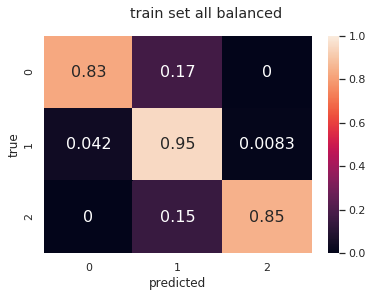

In [56]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

resnet10_checkpoint_path_base = "/data/jma/model/synthetic_data/convnet/train_set_balanced/"

kernel_sizes = [[10,7,3]]
filter_sizes = [8]
snnl_weights = [0.00]

data_path = "./data/data_relabeled_png/"

random_seed = 777

image_paths = load_data_util.load_image_paths(data_path)
train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed)

eval_input_fn = lambda : load_data_util.load(data_path, eval_paths, training=False, augment=False, shuffle=False, batch_size=64)


eval_paths = load_data_util.load_image_paths("./data/split_and_balanced/eval/")
eval_input_fn = lambda : load_data_util.load("./data/split_and_balanced/eval/", eval_paths, training=False, augment=False, shuffle=False, batch_size=64)



for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()

            title = "model_balanced_filter8"
#             title = "model_balanced_train_set_filter8"
            model_path = resnet10_checkpoint_path_base + title +"/"
            print(model_path)
        
        
            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size)
            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            values = model.predict(eval_input_fn)


            original_labels = path_to_label(eval_paths, data_path)
            predicted_labels = list(values)

            cm = tf.confusion_matrix(original_labels, predicted_labels)
            cm = tf.to_float(cm)

            cm = cm.numpy()
            
            row_sums = cm.sum(axis=1)
            cm = cm / row_sums[:, np.newaxis]
            
            df_cm = pd.DataFrame(cm, range(3), range(3))
            #plt.figure(figsize = (10,7))

            sns.set(font_scale=1)#for label size
            plt.suptitle("train set all balanced")
            ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1)# font size
            ax.set(xlabel='predicted', ylabel='true')
            plt.show()
        

## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


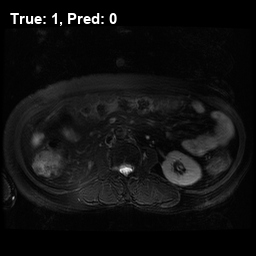

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png//"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    